In [1]:
import os
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import palettable
from collections import Counter
from collections import namedtuple

In [2]:
changed_dir = False

In [3]:
if(not changed_dir):
    os.chdir(os.path.join(os.getcwd(), "../"))
    sys.path.append(os.getcwd())
    print(os.getcwd())
    changed_dir = True

import common

/mnt/E/CMU/Projects/HeteroSketch/query-planner/gurobi


In [4]:
FONT_SIZE = 8
MARKER_SIZE = 6
LINE_WIDTH = 2
HANDLE_LENGTH = 2.5
FIGURE_SIZE = (16/3, 9/3)
colors = palettable.colorbrewer.qualitative.Paired_12.hex_colors
colors_idxs = [5, 1, 3, 7, 9, 11]
linestyles = ['-', '--']
hatches = ['-', '\\\\', '', 'X']
markers = ['x', '^', 'D', 'o', '.', 's']

plt.rcParams.update({
    'font.size': FONT_SIZE,
    'lines.linewidth': LINE_WIDTH
})
plt.rc('pdf', fonttype=42)

# https://jwalton.info/Embed-Publication-Matplotlib-Latex/

def get_fig_size(col=1, height_frac=1):
    width = LATEX_LINE_WIDTH_IN * col
    height = width * GOLDEN_RATIO * height_frac
    return (width, height)


def pt2in(pt):
    return pt/72.72


LATEX_TEXT_WIDTH_PT = 505.89
LATEX_TEXT_WIDTH_IN = pt2in(LATEX_TEXT_WIDTH_PT)
LATEX_LINE_WIDTH_PT = 241.02039
LATEX_LINE_WIDTH_IN = pt2in(LATEX_LINE_WIDTH_PT)
GOLDEN_RATIO = (5**.5 - 1) / 2

In [5]:
def read_data(fpath):
    with open(fpath+'_md_list.pickle', 'rb') as f:
        md_list = pickle.load(f)
    with open(fpath+'_devices.pickle', 'rb') as f:
        devices = pickle.load(f)

    all_data = {}
    for dnum, d in enumerate(devices):
        all_data.setdefault(d.__class__.__name__, [])
        all_data[d.__class__.__name__].append(md_list[dnum])
    return all_data

Scheme: Joint+Cluster, Device: CPU, Sketches: 758.9999980377506
Scheme: Greedy+Cluster, Device: CPU, Sketches: 5583.000000869727


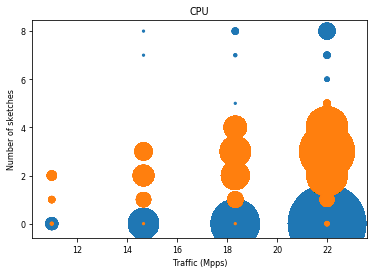

Scheme: Joint+Cluster, Device: Netronome, Sketches: 7354.000001620657
Scheme: Greedy+Cluster, Device: Netronome, Sketches: 2114.999996469355


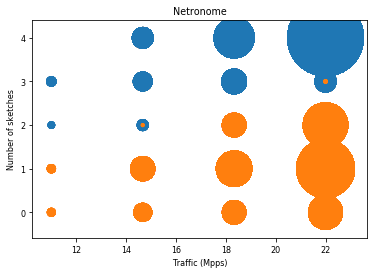

Scheme: Joint+Cluster, Device: P4, Sketches: 219.0
Scheme: Greedy+Cluster, Device: P4, Sketches: 607.0


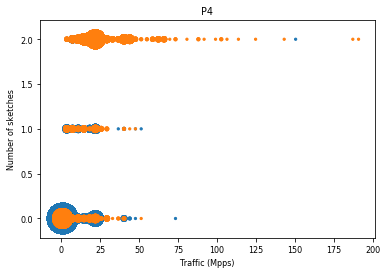

In [6]:
def traffic_correlation_plot(all_data, device, label):
    k = device
    v = all_data[k]
    sv = sorted(v, key=lambda x: 1000/x.ns_req)
    all_traffic = list(map(lambda x: 1000/x.ns_req, sv))
    num_sketches = list(map(lambda x: x.rows_tot/3, sv))
    x = all_traffic
    y = num_sketches
    # count the occurrences of each point
    c = Counter(zip(x,y))
    # create a list of the sizes, here multiplied by 10 for scale
    s = [5*c[(xx,yy)] for xx,yy in zip(x,y)]
    plt.scatter(all_traffic, num_sketches, s=s, label=label)
    total_sketches = np.sum(list(map(lambda x: x.rows_tot/3, v)))
    print("Scheme: {}, Device: {}, Sketches: {}".format(label, device, total_sketches))

ugr_data = read_data('outputs/nsdi21/2_20pods_UGR.results')
for device in ugr_data.keys():
    traffic_correlation_plot(read_data('outputs/nsdi21/2_20pods.results'), 
                             device, 'Joint+Cluster')
    traffic_correlation_plot(ugr_data, 
                             device, 'Greedy+Cluster')
    plt.xlabel('Traffic (Mpps)')
    plt.ylabel('Number of sketches')
    plt.title(device)
    # plt.legend()
    plt.show()

In [7]:
for k, v in all_data.items():
    sv = sorted(v, key=lambda x: 1000/x.ns_req)
    all_traffic = list(map(lambda x: 1000/x.ns_req, sv))
    num_sketches = list(map(lambda x: x.rows_tot/3, sv))
    fig, ax = plt.subplots()
    x = all_traffic
    y = num_sketches
    t = np.arange(len(x))
    ax.fill_between(t, x)
    ax.set_ylabel('Traffic (Mpps)')
    ax2 = ax.twinx()
    ax2.plot(y, color='r')
    ax2.set_ylabel('Number of sketches')
    plt.title(k)
    plt.show()

NameError: name 'all_data' is not defined

In [8]:
import math
LINE_WIDTH = [2, 2]
colors_idxs = [5, 1, 3, 7, 9, 11]
#colors_idxs = [5, 3, 7, 9, 11]
linestyles = ['-', '--',(0, (3, 1, 1, 1))] #(0, (3, 5, 1, 5))]
def util_hist(all_data, label, ax, idx):
    print(label, np.sum(list(map(lambda x: x.cores_sketch + x.cores_dpdk, all_data['CPU']))))
    util_fun = lambda x: (x.ns_dpdk * x.cores_dpdk + x.ns_sketch * x.cores_sketch)/((x.cores_sketch + x.cores_dpdk) * x.ns_req)
    utilization = list(map(util_fun, all_data['CPU']))
    utilization = []
    for x in all_data['CPU']:
        utilization.extend([x.ns_dpdk/x.ns_req]*math.ceil(x.cores_dpdk) + [x.ns_sketch/x.ns_req]*math.ceil(x.cores_sketch))
    utilization = sorted(utilization)
    print(np.mean(utilization))
    # print(utilization)
#     a = utilization
#     # a is the data array
#     x = np.sort(a)
#     y = np.arange(len(x))/float(len(x))
#     plt.plot(x, y, label=label)
    ax.plot(utilization, label=label, lw=LINE_WIDTH[idx], linestyle=linestyles[idx], c=colors[colors_idxs[idx]])
    #plt.hist(utilization, density=True, cumulative=1,
    #         histtype='step', alpha=0.8, label=label)

    
def cores_hist(all_data, label, ax):
    util_fun = lambda x: (x.cores_sketch + x.cores_dpdk)
    utilization = list(map(util_fun, all_data['CPU']))
    utilization = sorted(utilization)
    # plt.plot(utilization, label=label)
    # print(utilization)
    a = utilization
    # a is the data array
    x = np.sort(a)
    y = np.arange(len(x))/float(len(x))
    ax.plot(x, y, label=label)

Greedy+Cluster 9752.0
0.7589781973092943
HeteroSketch 7907.0
0.898171754670396


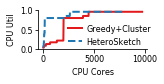

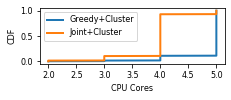

In [9]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
fig, ax = plt.subplots(figsize=get_fig_size(0.5/0.85, 0.6))
for idx, (fpath, label) in enumerate([('outputs/nsdi21/2_20pods_UGR.results', 'Greedy+Cluster'), 
                                      ('outputs/nsdi21/2_20pods.results', 'HeteroSketch')]):
    util_hist(read_data(fpath), label, ax, idx)
ax.set_xlabel('CPU Cores')
ax.set_ylabel('CPU Util')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.yaxis.grid(True, which='minor')
ax.set_yticks([0, 0.5, 1])
ax.tick_params(labelsize=FONT_SIZE, pad=2)
legend = plt.legend(loc='lower right', numpoints=1, bbox_to_anchor=(1.1, -0.1),
                    ncol=1, prop={'size': FONT_SIZE}, columnspacing=0.5,
                    handlelength=1.8, handletextpad=0.5)
legend.set_frame_on(False)
plt.savefig('core-util.png', bbox_inches='tight', dpi=700)

fig, ax = plt.subplots(figsize=get_fig_size(1, 0.5))
for idx, (fpath, label) in enumerate([('outputs/nsdi21/2_20pods_UGR.results', 'Greedy+Cluster'), 
                                      ('outputs/nsdi21/2_20pods.results', 'Joint+Cluster')]):
    cores_hist(read_data(fpath), label, ax)
plt.xlabel('CPU Cores')
plt.ylabel('CDF')
plt.legend()
plt.show()

In [ ]:
# plt.hist(utilization, density=True, cumulative=1,
#          histtype='step', alpha=0.8, color='k')
# plt.xlabel('CPU utilization')
# plt.ylabel('CDF')
# plt.show()

In [ ]:
all_data = read_data('outputs/nsdi21/2_20pods_UGR.results')
utilization = list(map(lambda x: x.ns/x.ns_req, all_data['CPU']))
plt.hist(utilization, density=True, cumulative=-1,
         histtype='step', alpha=0.8, label=label)

In [ ]:
np.sum(list(map(lambda x: x.cores_sketch + x.cores_dpdk, all_data['CPU'])))

In [ ]:
plt.hist(list(map(lambda x: x.cores_sketch+x.cores_dpdk, all_data['CPU'])))

In [ ]:
all_data_ugr = read_data('outputs/nsdi21/2_20pods_UGR.results')
all_data_netmon = read_data('outputs/nsdi21/2_20pods.results')

In [ ]:
all_data_netmon['Netronome']

In [ ]:
def netro_mem_util_hist(all_data, label, idx):
    util_fun = lambda x: (x.ns_mem_max/x.ns_req)
    utilization = list(map(util_fun, all_data['Netronome']))
    utilization = sorted(utilization)
    # print(utilization)
    a = utilization
    # a is the data array
    x = np.sort(a)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label=label, lw=2, linestyle=linestyles[idx], c=colors[colors_idxs[idx]])
    # plt.plot(utilization, label=label)
    
def netro_mem_count_hist(all_data, label):
    util_fun = lambda x: x.mem_tot
    utilization = list(map(util_fun, all_data['Netronome']))
    utilization = sorted(utilization)
    # print(utilization)
    a = utilization
    # a is the data array
    x = np.sort(a)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label=label)
    # plt.plot(utilization, label=label)

def netro_me_util_hist(all_data, label, idx):
    util_fun = lambda x: (x.ns_hash + x.ns_fwd)/(2 * x.ns_req)
    utilization = list(map(util_fun, all_data['Netronome']))
    for x in all_data['Netronome']:
        utilization.extend([x.ns/x.ns_req]*math.ceil(x.micro_engines))
    utilization = sorted(utilization)
#     # print(utilization)
#     a = utilization
#     # a is the data array
#     x = np.sort(a)
#     y = np.arange(len(x))/float(len(x))
#     plt.plot(x, y, label=label)
    plt.plot(utilization, label=label, lw = 2, linestyle=linestyles[idx], c=colors[colors_idxs[idx]])
    
def netro_me_count_hist(all_data, label):
    util_fun = lambda x: x.micro_engines
    utilization = list(map(util_fun, all_data['Netronome']))
    utilization = sorted(utilization)
    # print(utilization)
    a = utilization
    # a is the data array
    x = np.sort(a)
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, label=label)
    # plt.plot(utilization, label=label)

In [ ]:
linestyles = ['-', '--',(0, (3, 1, 1, 1))] #(0, (3, 5, 1, 5))]
fig, ax = plt.subplots(figsize=get_fig_size(0.5/0.85, 0.6))
for idx, (fpath, label) in enumerate([('outputs/nsdi21/2_20pods_UGR.results', 'Greedy+Cluster'), 
                                      ('outputs/nsdi21/2_20pods.results', 'Joint\n+Cluster')]):
    netro_mem_util_hist(read_data(fpath), label, idx)
ax.set_xlabel('NIC Mem BW util')
ax.set_ylabel('CDF')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelsize=FONT_SIZE, pad=2)
ax.set_yticks([0, 0.5, 1])
# legend = plt.legend(loc='upper left', numpoints=1, bbox_to_anchor=(0, 1.3),
#                     ncol=1, prop={'size': FONT_SIZE}, columnspacing=0.5,
#                     handlelength=HANDLE_LENGTH, handletextpad=0.5)
# legend.set_frame_on(False)
# plt.show()
plt.savefig('netro-mem-util-half.pdf', bbox_inches='tight')

linestyles = ['-', '--',(0, (3, 1, 1, 1))] #(0, (3, 5, 1, 5))]
fig, ax = plt.subplots(figsize=get_fig_size(0.5/0.85, 0.6))
for idx, (fpath, label) in enumerate([('outputs/nsdi21/2_20pods_UGR.results', 'Greedy+Cluster'), 
                                      ('outputs/nsdi21/2_20pods.results', 'Joint+Cluster')]):
    netro_me_util_hist(read_data(fpath), label, idx)
ax.set_xlabel('Netronome \nMicro-engines (ME)')
ax.set_ylabel('ME Utilization')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(labelsize=FONT_SIZE, pad=2)
legend = plt.legend(loc='lower right', numpoints=1, bbox_to_anchor=(1.1, -0.15),
                    ncol=1, prop={'size': FONT_SIZE}, columnspacing=0.5,
                    handlelength=HANDLE_LENGTH, handletextpad=0.5)
legend.set_frame_on(False)
#plt.show()
plt.savefig('netro-me-util-half.pdf', bbox_inches='tight')

plt.subplots()
for fpath, label in [('outputs/nsdi21/2_20pods.results', 'Joint+Cluster'), 
                     ('outputs/nsdi21/2_20pods_UGR.results', 'Greedy+Cluster')]:
    netro_mem_count_hist(read_data(fpath), label)
plt.xlabel('Netronome NIC Memory Allocated (KB)')
plt.ylabel('CDF')
plt.legend()
plt.show()

for fpath, label in [('outputs/nsdi21/2_20pods.results', 'Joint+Cluster'), 
                     ('outputs/nsdi21/2_20pods_UGR.results', 'Greedy+Cluster')]:
    netro_me_count_hist(read_data(fpath), label)
plt.xlabel('Netronome NIC Micro Engines allocated')
plt.ylabel('CDF')
plt.legend()
plt.show()

In [ ]:
all_data['Netronome']